In [13]:
%matplotlib inline

In [14]:
import numpy as np
from PIL import Image,ImageDraw,ImageFont
import StringIO
from scipy import misc

#https://en.wikipedia.org/wiki/List_of_CJK_fonts
#https://en.wikipedia.org/wiki/WenQuanYi
#http://wenq.org/wqy2/index.cgi?action=browse&id=Home&lang=en
chinese_font_filename = "WenQuanYi Micro Hei.ttf"

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
chinese_font = FontProperties(fname = chinese_font_filename)

In [15]:
fontsize = 40
dim = 50

def plot_character(char, fontsize=None, dim=None, margin=10):

    # sample text and font
    wenquanyi = ImageFont.truetype(chinese_font_filename, fontsize, encoding="unic")

    if dim is None:
        dim = fontsize + margin

    canvas = Image.new('LA',(dim, dim), (0,))

    draw = ImageDraw.Draw(canvas)
    draw.text((margin/2,margin/2), char, font = wenquanyi, fill = (255,))

    output = StringIO.StringIO()
    # save the blank canvas to a file
    canvas.save(output, "PNG")
    im = misc.imread(output,mode = 'L')
    return im

output = plot_character(unichr(19968+5000), fontsize, dim)

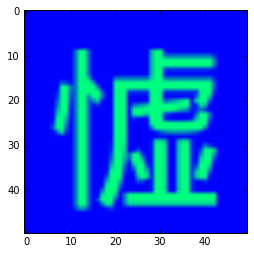

In [16]:
import matplotlib.pylab as pylab
pylab.winter()
pylab.imshow(output)
pylab.show()

In [17]:
#Chinese Character Range
#http://stackoverflow.com/questions/1366068/whats-the-complete-range-for-chinese-characters-in-unicode

In [18]:
character_ranges = [
    (int('4E00',16),int('9FFF',16)),#common characters
    (int('3400',16),int('4DFF',16)),#rare
    (int('20000',16),int('2A6DF',16)) ,#rare, historic
    (int('2B740',16),int('2B81F',16)) ,#uncommon, some in current use    
]

In [19]:
cols = 4

start = character_ranges[0][0]
characters = np.zeros((dim*cols,dim*cols),dtype = np.uint8)

for i,c in enumerate(range(start,start+cols*cols)):
    output = plot_character(unichr(c),fontsize, dim=dim)
    characters[(i%cols)*dim:((i%cols)+1)*dim,(i/cols)*dim:((i/cols)+1)*dim] = output[:,:]

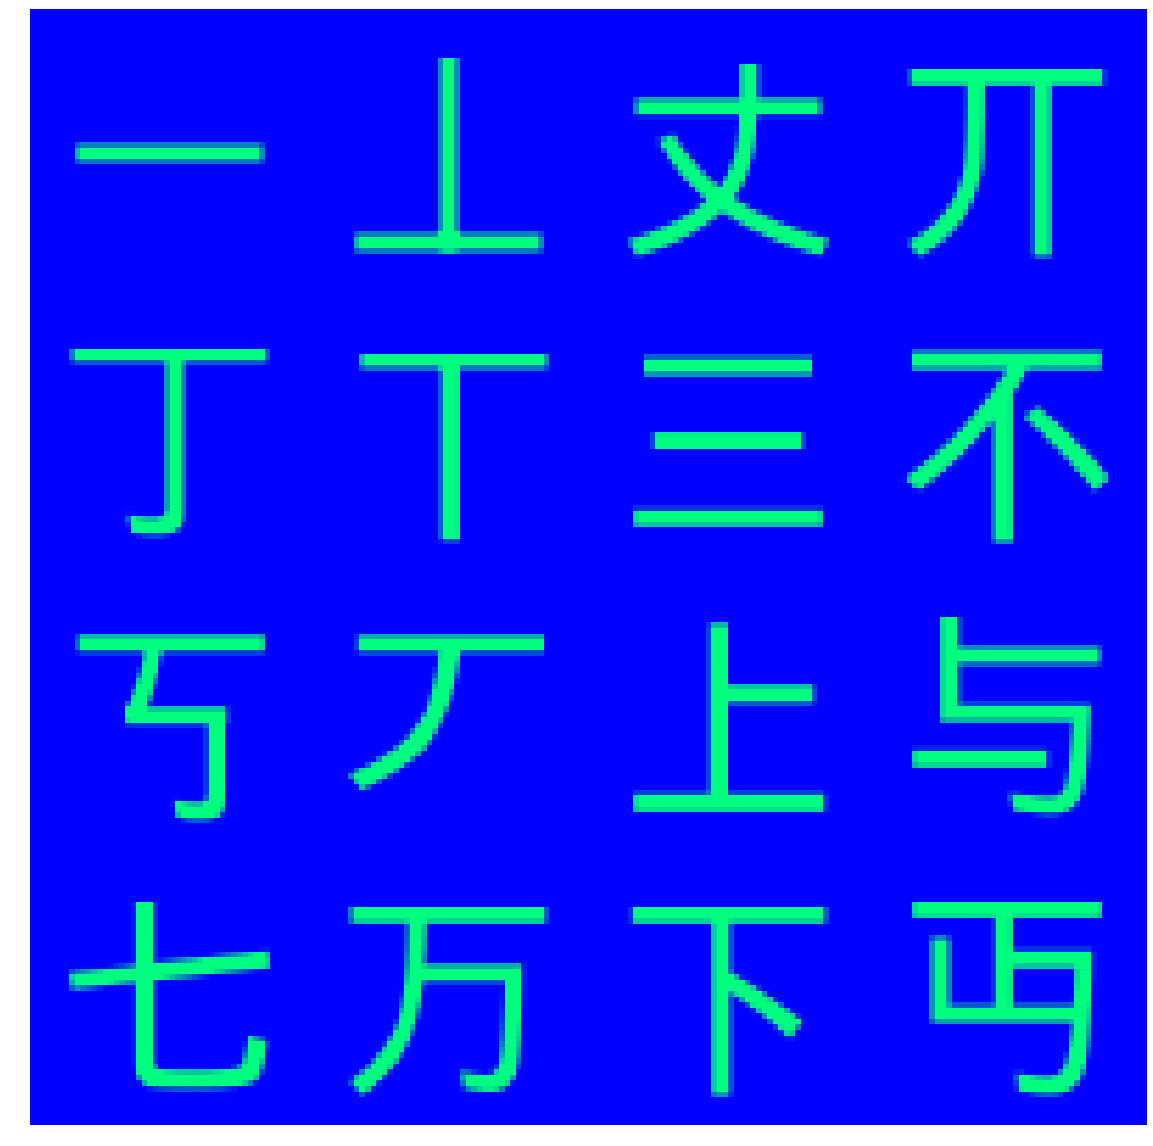

In [21]:
pylab.winter()
pylab.figure(figsize = (20,20))
pylab.imshow(characters, interpolation='nearest')
pylab.axis('off')
pylab.grid((dim,dim),which='major')

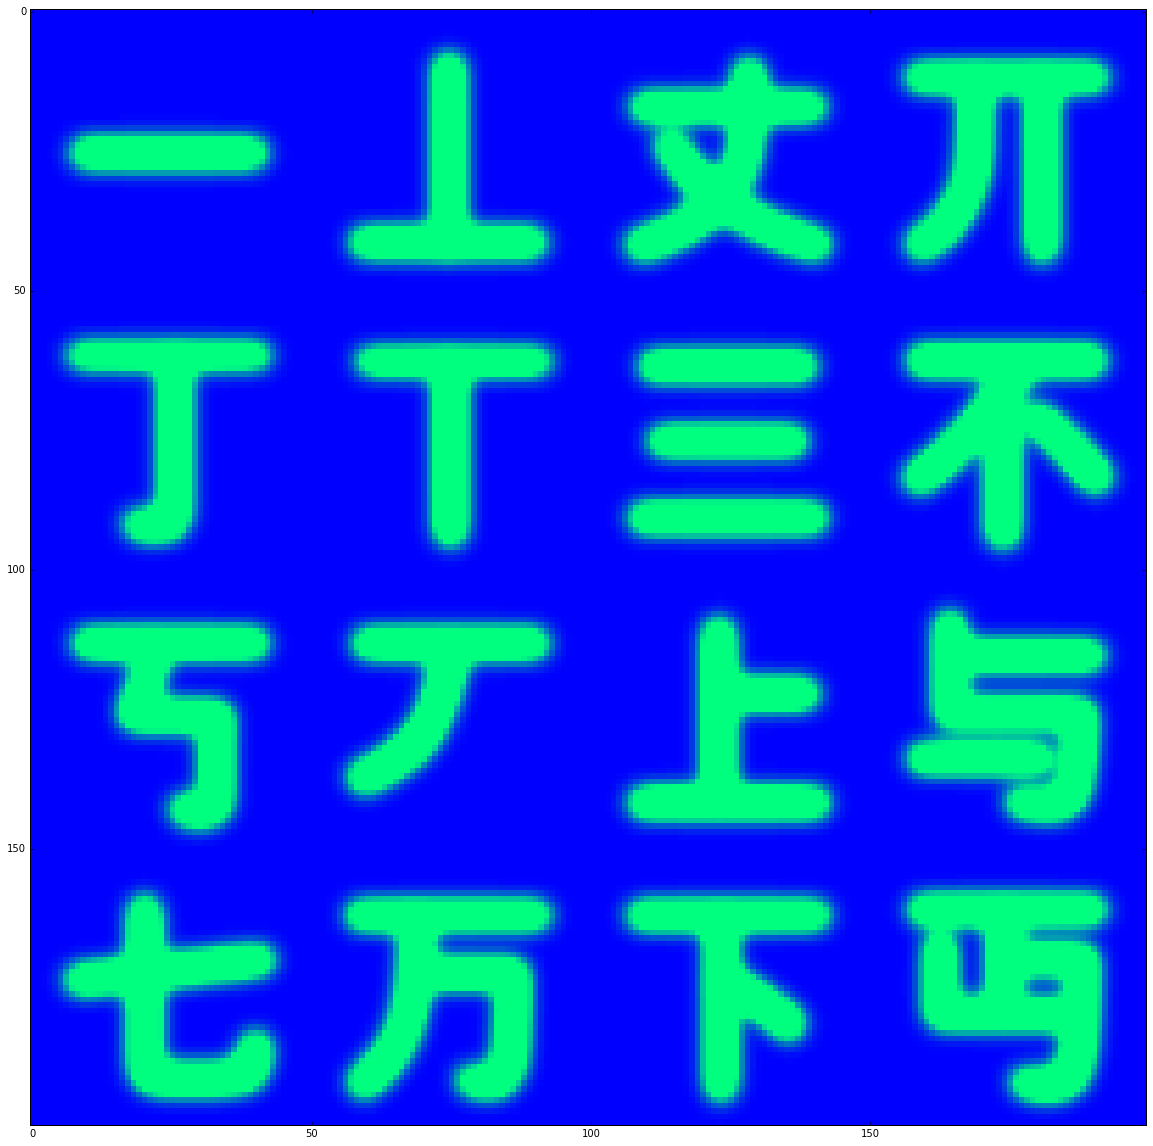

In [22]:
from scipy import ndimage

def blur_and_saturate(image, radius=2, factor=4):

    converted_image = image.astype(np.uint)
    blurred_image = ndimage.gaussian_filter(converted_image, radius)
    saturated_image = np.clip(blurred_image*factor,0,255)
    return saturated_image.astype(np.uint8)

pylab.figure(figsize=(20,20))
pylab.imshow(blur_and_saturate(characters), interpolation='nearest')

In [24]:
#Let's calculate a simple distance matrix!

fs = 60
d = 80
margin= d / 4
N = 10
start = character_ranges[0][0]

similarity = np.zeros((N,N))

character_codes = np.zeros((N,),dtype = np.uint)
small_characters = np.zeros((N,d,d))

for i in range(N):
    ci = start+i
    character_codes[i] = ci
    small_characters[i] = blur_and_saturate(plot_character(unichr(ci),fs, dim=d, margin=margin),radius=2,factor=3)

for i in range(N):
    for j in range(N):
        output_i = small_characters[i]
        output_j = small_characters[j]
        similarity[i,j] = similarity[j,i] = np.sum(output_i/np.sqrt(np.sum(output_i*output_i))*output_j/np.sqrt(np.sum(output_j*output_j)))**2



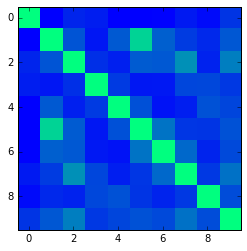

In [25]:
pylab.imshow(similarity,interpolation='nearest')

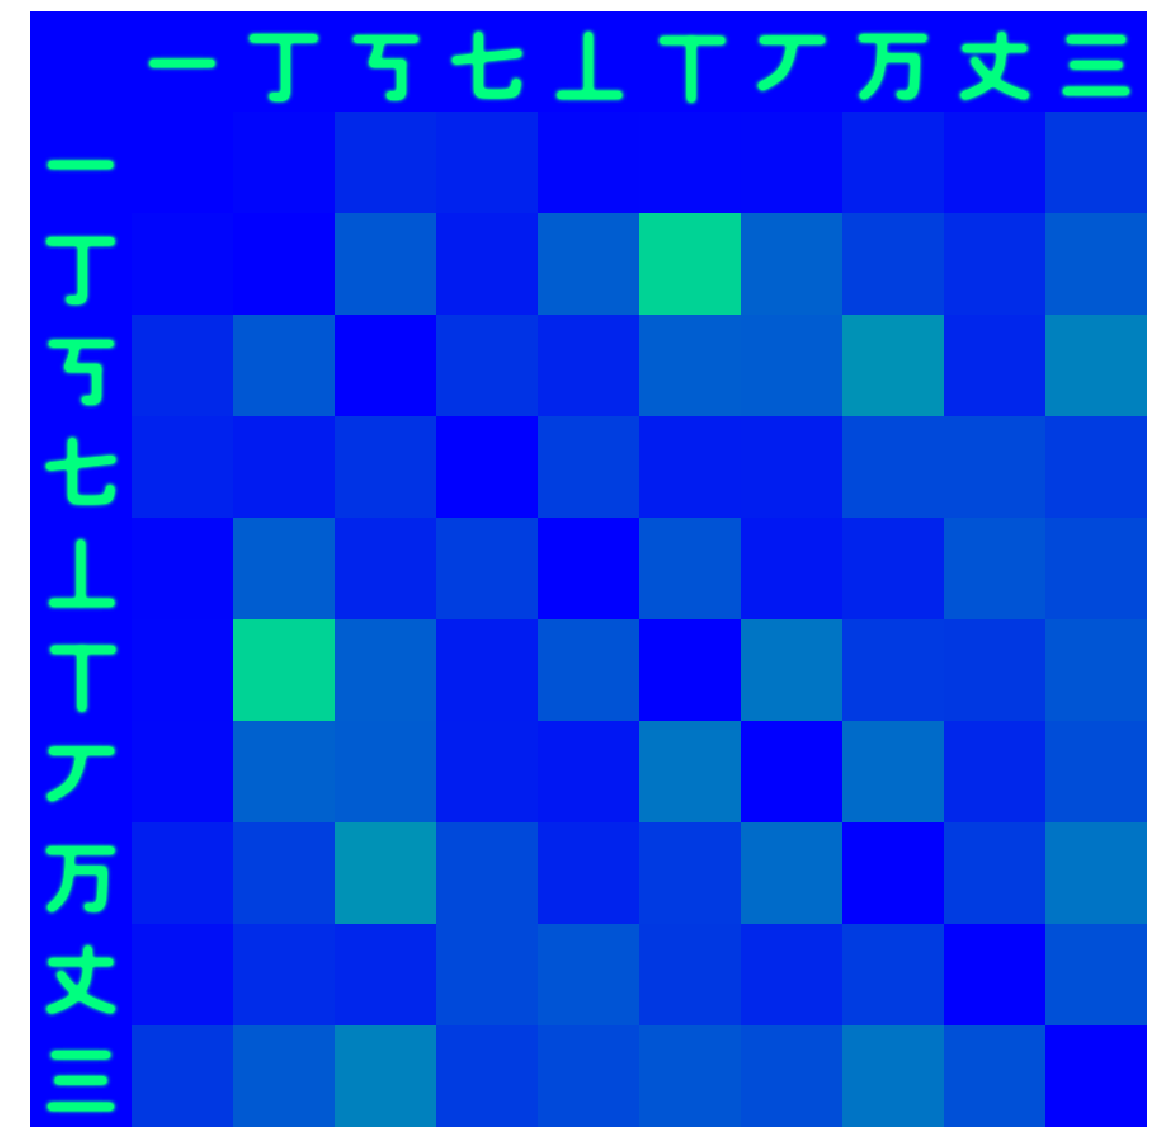

In [26]:
similarity_with_characters = np.zeros(((N+1)*d,(N+1)*d))

for i in range(N):
    similarity_with_characters[(i+1)*d:(i+2)*d,0:d] = small_characters[i]
    similarity_with_characters[0:d,(i+1)*d:(i+2)*d] = small_characters[i]

for i in range(N):
    for j in range(N):
        if i == j:
            continue
        similarity_with_characters[(i+1)*d:(i+2)*d,(j+1)*d:(j+2)*d] = similarity[i,j]*255

pylab.figure(figsize=(20,20))
pylab.axis('off')
pylab.imshow(similarity_with_characters, interpolation='nearest')

In [ ]:
#http://yann.lecun.com/exdb/publis/pdf/ranzato-nips-07.pdf
#http://stats.stackexchange.com/questions/118199/what-are-the-differences-between-sparse-coding-and-autoencoder

In [14]:
#http://www.pyimagesearch.com/2014/09/22/getting-started-deep-learning-python/

In [27]:
X = small_characters.reshape(N,d*d)

In [28]:
X = (X - np.min(X, 0)) / (np.max(X, 0) + 0.0001)

In [31]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2)
kmeans.fit(X)

labels = kmeans.labels_

from collections import defaultdict
characters_by_group = defaultdict(list)
indexes_by_group = defaultdict(list)

for i,label in enumerate(labels):
    characters_by_group[label].append(character_codes[i])
    indexes_by_group[label].append(i)

In [32]:
for group,characters in characters_by_group.items():
    print group," ".join([unichr(c) for c in characters]),"\n\n"

0 一 丁 丂 丄 丅 丆 万 三 


1 七 丈 




In [34]:
import random
from scipy import ndimage, misc
def distort_image(image,rotate = 4.0, shift = 4):
    return misc.imresize(ndimage.shift(ndimage.rotate(image,random.gauss(0,rotate)),(random.gauss(0,shift),random.gauss(0,shift))),image.shape)

def scale_image(image,factor):
    return ndimage.zoom(image,factor)

In [35]:
NN = 10
M = 1000
factor = 0.2
D = int(small_characters.shape[1]*factor)

small_characters_plus_distorted = np.zeros((NN*M,D,D),dtype=np.float32)
Y = np.zeros(NN*M,dtype=np.int32)

for i in range(NN):
    for j in range(M):
        c = i
        small_characters_plus_distorted[i*M+j] = scale_image(distort_image(small_characters[c],rotate=1,shift=2),factor)
        Y[i*M+j] = i

X = small_characters_plus_distorted.reshape((NN*M,D*D))
#X = small_characters_plus_distorted.reshape(NN*M,small_characters_plus_distorted.shape[1]**2)
X = 1.0-(X - np.min(X, 0)) / (np.max(X, 0) + 0.0001)

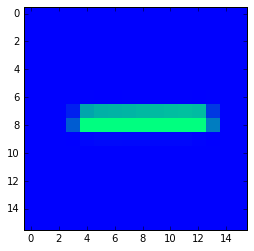

In [36]:
pylab.imshow(small_characters_plus_distorted[740],interpolation='nearest')

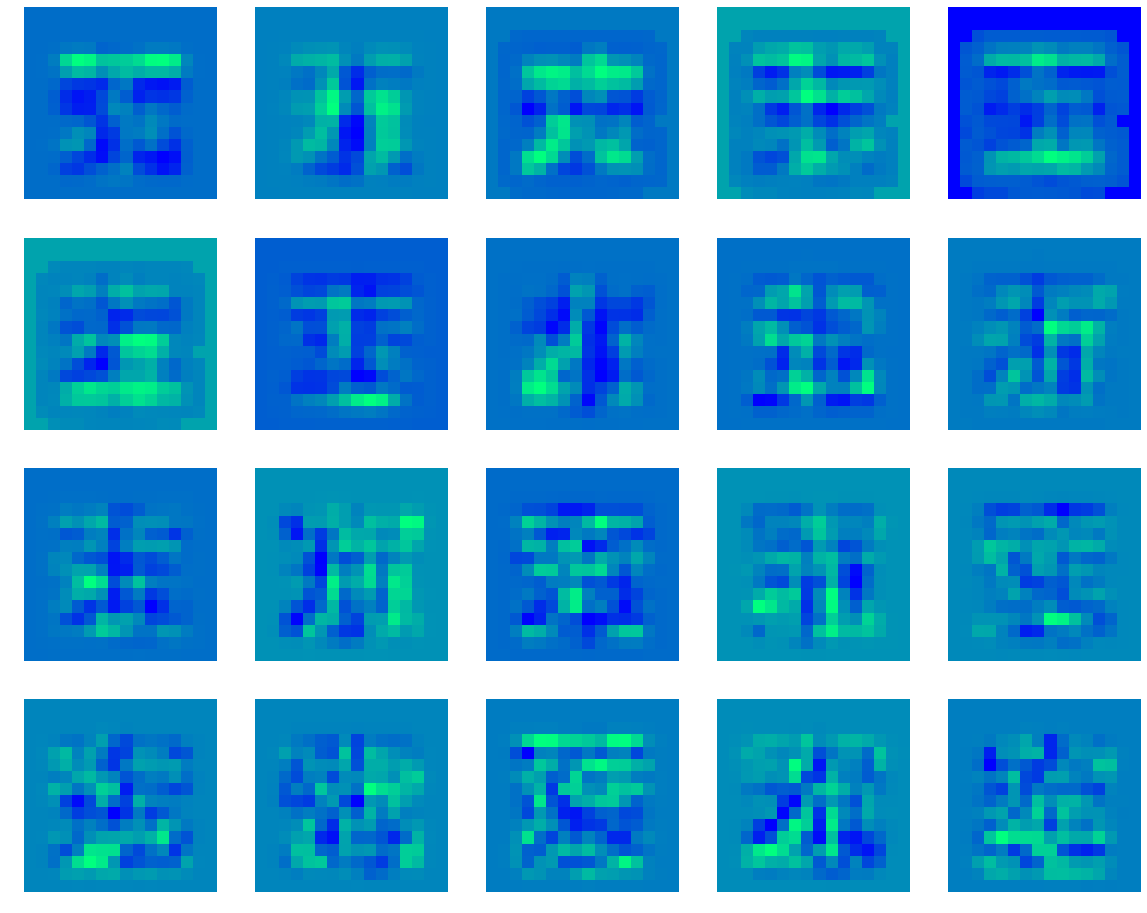

In [37]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
pca.fit(X)

pylab.figure(figsize=(20,20))

xd = np.int(np.sqrt(X.shape[1]))

components = pca.components_.reshape(pca.components_.shape[0],xd,xd)

for i in range(pca.n_components):
    pylab.subplot(np.ceil(np.sqrt(pca.n_components)),np.ceil(np.sqrt(pca.n_components)),i+1)
    pylab.axis('off')
    pylab.imshow(components[i],interpolation='nearest')


(40, 40)


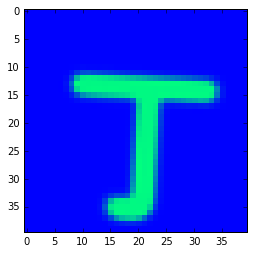

In [42]:
res = scale_image(distort_image(small_characters[1]),0.5)
print res.shape
pylab.imshow(res,interpolation='nearest')

[BernoulliRBM] Iteration 1, pseudo-likelihood = -84.21, time = 0.24s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -84.09, time = 0.31s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -84.54, time = 0.29s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -84.48, time = 0.43s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -84.14, time = 0.28s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -84.55, time = 0.29s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -84.13, time = 0.29s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -84.46, time = 0.29s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -84.13, time = 0.32s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -84.47, time = 0.27s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -84.25, time = 0.30s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -84.09, time = 0.29s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -83.81, time = 0.29s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -84.10, time = 0.28s
[BernoulliRBM] Iteration 15, 

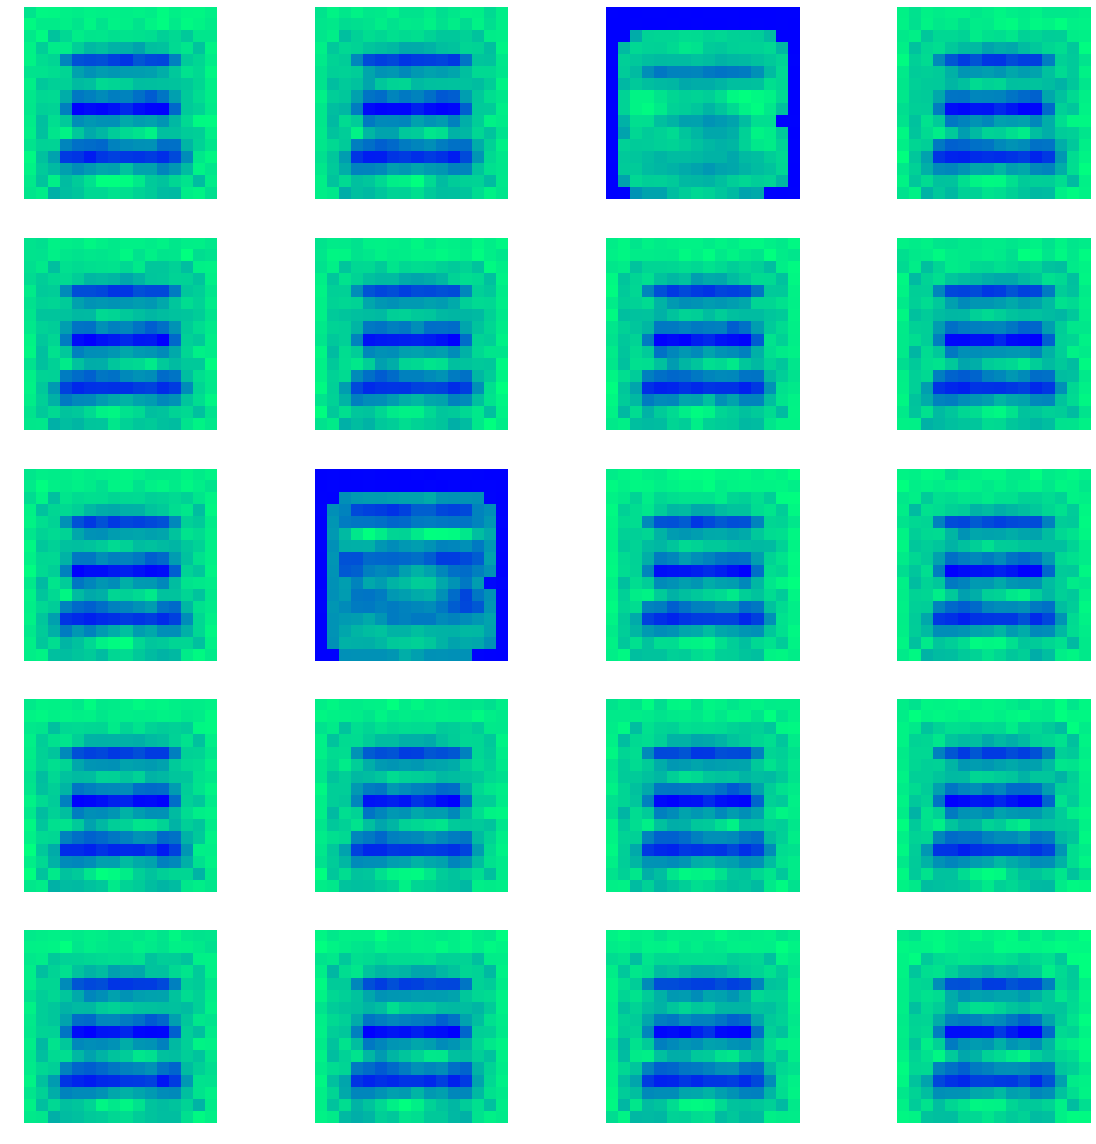

In [45]:
#Single reduced Boltzmann machine training
from sklearn.neural_network import BernoulliRBM
rbm = BernoulliRBM(random_state=200, verbose=True)
rbm.learning_rate = 0.01
rbm.n_iter = 200
rbm.n_components = 20
rbm.fit(X)

pylab.figure(figsize=(20,20))
xd = np.int(np.sqrt(X.shape[1]))
components = rbm.components_.reshape(rbm.components_.shape[0],xd,xd)
for i in range(rbm.n_components):
    pylab.subplot(np.ceil(np.sqrt(rbm.n_components)),np.floor(np.sqrt(rbm.n_components)),i+1)
    pylab.axis('off')
    pylab.imshow(components[i],interpolation='nearest')

[BernoulliRBM] Iteration 1, pseudo-likelihood = -88.26, time = 0.06s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -83.44, time = 0.11s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -82.31, time = 0.13s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -83.73, time = 0.11s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -82.73, time = 0.09s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -83.98, time = 0.12s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -83.34, time = 0.10s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -81.13, time = 0.11s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -78.83, time = 0.13s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -76.86, time = 0.11s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -78.24, time = 0.14s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -77.69, time = 0.10s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -78.12, time = 0.11s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -77.11, time = 0.11s
[BernoulliRBM] Iteration 15, 

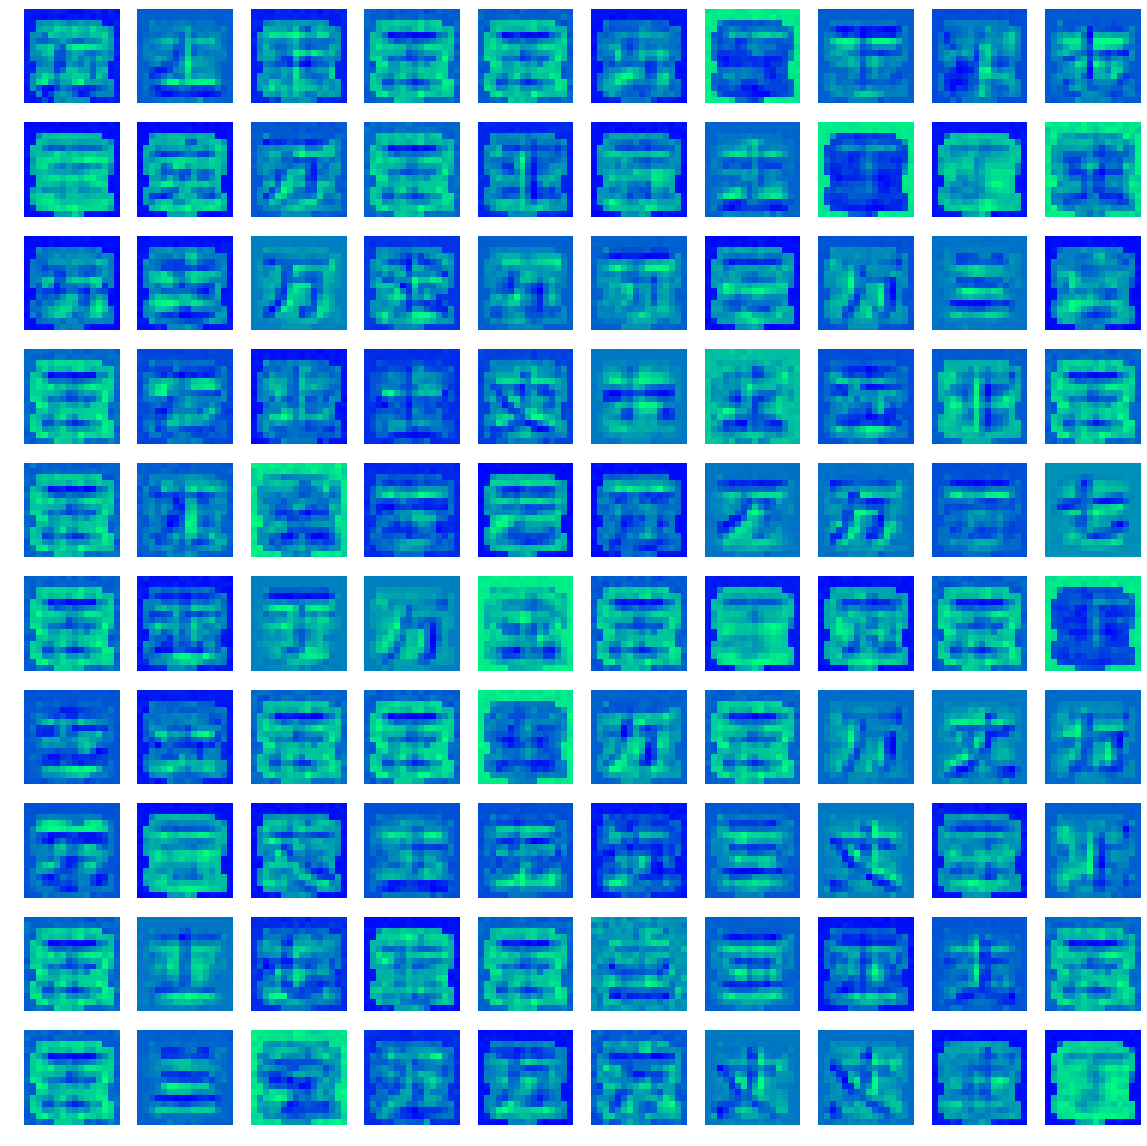

In [204]:
from sklearn.pipeline import Pipeline
from sklearn import linear_model, datasets, metrics

# Models we will use
logistic = linear_model.LogisticRegression()
rbm = BernoulliRBM(random_state=0, verbose=True)

classifier = Pipeline(steps=[('rbm', rbm), ('logistic', logistic)])

###############################################################################
# Training

# Hyper-parameters. These were set by cross-validation,
# using a GridSearchCV. Here we are not performing cross-validation to
# save time.
rbm.learning_rate = 0.06
rbm.n_iter = 100
# More components tend to give better prediction performance, but larger
# fitting time
rbm.n_components = 100
logistic.C = 6000.0

# Training RBM-Logistic Pipeline
classifier.fit(X, Y)

# Training Logistic regression
#logistic_classifier = linear_model.LogisticRegression(C=100.0)
#logistic_classifier.fit(X, Y)


pylab.figure(figsize=(20,20))
xd = np.int(np.sqrt(X.shape[1]))
components = rbm.components_.reshape(rbm.components_.shape[0],xd,xd)
for i in range(rbm.n_components):
    pylab.subplot(np.ceil(np.sqrt(rbm.n_components)),np.floor(np.sqrt(rbm.n_components)),i+1)
    pylab.axis('off')
    pylab.imshow(components[i],interpolation='nearest')

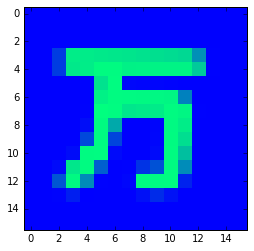

In [47]:
pylab.imshow(small_characters_plus_distorted[M*7+12],interpolation='nearest')

In [63]:
from sklearn.cross_validation import train_test_split

XX = X.reshape((X.shape[0],1,X.shape[1]))

(trainX, testX, trainY, testY) = train_test_split(XX, Y, test_size = 0.33)

In [64]:
# Create the classifier
import lasagne

def build_cnn(input_var=None):
    # Input layer, as usual:
    network = lasagne.layers.InputLayer(shape=(None,1,trainX[0].shape[0],trainX[0].shape[1]),
                                        input_var=input_var)
    # This time we do not apply input dropout, as it tends to work less well
    # for convolutional layers.

    # Convolutional layer with 32 kernels of size 5x5. Strided and padded
    # convolutions are supported as well; see the docstring.
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=32, filter_size=(5, 5),
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform())
    # Expert note: Lasagne provides alternative convolutional layers that
    # override Theano's choice of which implementation to use; for details
    # please see http://lasagne.readthedocs.org/en/latest/user/tutorial.html.

    # Max-pooling layer of factor 2 in both dimensions:
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))

    # Another convolution with 32 5x5 kernels, and another 2x2 pooling:
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=32, filter_size=(5, 5),
            nonlinearity=lasagne.nonlinearities.rectify)
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))

    # A fully-connected layer of 256 units with 50% dropout on its inputs:
    network = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.5),
            num_units=256,
            nonlinearity=lasagne.nonlinearities.rectify)

    # And, finally, the 10-unit output layer with 50% dropout on its inputs:
    network = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.5),
            num_units=10,
            nonlinearity=lasagne.nonlinearities.softmax)

    return network


In [65]:
import theano.tensor as T
import theano
input_var = T.tensor4('inputs')
target_var = T.ivector('targets')

network = build_cnn(input_var)

prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
loss = loss.mean()

ValueError: Cannot create Layer with a non-positive input_shape dimension. input_shape=(None, 32, -3, 252), self.name=None

In [37]:
params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.nesterov_momentum(
        loss, params, learning_rate=0.01, momentum=0.9)

In [38]:
test_prediction = lasagne.layers.get_output(network, deterministic=True)
test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,
                                                        target_var)
test_loss = test_loss.mean()

In [39]:
test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                  dtype=theano.config.floatX)

In [40]:
train_fn = theano.function([input_var, target_var], loss, updates=updates)

In [41]:
val_fn = theano.function([input_var, target_var], [test_loss, test_acc])

In [70]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]


num_epochs = 500
import time
for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(trainX, trainY, 50, shuffle=True):
        inputs, targets = batch
        train_err += train_fn(inputs, targets)
        train_batches += 1

    # And a full pass over the validation data:
    val_err = 0
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(testX, testY, 50, shuffle=False):
        inputs, targets = batch
        err, acc = val_fn(inputs, targets)
        val_err += err
        val_acc += acc
        val_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
    print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))


Epoch 1 of 500 took 6.612s
  training loss:		2.309947
  validation loss:		2.306972
  validation accuracy:		10.33 %
Epoch 2 of 500 took 6.523s
  training loss:		2.291671
  validation loss:		2.291724
  validation accuracy:		11.00 %
Epoch 3 of 500 took 6.622s
  training loss:		2.284882
  validation loss:		2.283754
  validation accuracy:		10.00 %
Epoch 4 of 500 took 6.706s
  training loss:		2.254170
  validation loss:		2.268481
  validation accuracy:		10.67 %
Epoch 5 of 500 took 6.483s
  training loss:		2.217671
  validation loss:		2.174303
  validation accuracy:		13.33 %
Epoch 6 of 500 took 6.425s
  training loss:		2.096535
  validation loss:		1.984689
  validation accuracy:		42.67 %
Epoch 7 of 500 took 6.464s
  training loss:		1.908492
  validation loss:		1.665527
  validation accuracy:		52.33 %
Epoch 8 of 500 took 6.407s
  training loss:		1.711508
  validation loss:		1.414720
  validation accuracy:		62.33 %
Epoch 9 of 500 took 6.749s
  training loss:		1.468216
  validation loss:		1.2140

KeyboardInterrupt: 